In [10]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import networkx as nx
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from docplex.mp.model import Model

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import StatevectorSampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [11]:
# Create the model
mdl = Model(name="SetBalancing")

'''
A = np.matrix([
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
    [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1, 0, 1, 0],
    [0, 1, 0, 1, 1, 0, 1, 0, 0, 1],
    [0, 0, 1, 1, 0, 1, 0, 0, 0, 1],
    [0, 1, 1, 0, 0, 0, 1, 0, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 0, 0, 1, 0, 1],
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 1],
    [1, 1, 0, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 0, 1, 0, 0, 0, 1, 0, 0],
    [1, 1, 0, 0, 0, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
])
This is the matrix for which we have demonstrated the result in the paper 
(which was run in a supercomputer envirnment). For the memory limitation reason, 
here we demonstrate result for a smaller size matrix. To run the simulation for 
the above matrix, it has to be just uncommented
'''
A = np.matrix([[1,1,0,1],
              [1,0,1,1],
              [1,0,0,1]])
m,n = A.shape

Q = A.T @ A

# Define variables
b = {j: mdl.binary_var(name=f"b_{j}") for j in range(n)}
b_vars = {j: 2 * b[j] - 1 for j in range(n)}

# Define objective
quadratic_terms = mdl.sum(Q[i, j] * b_vars[i] * b_vars[j] for i in range(n) for j in range(n))
mdl.minimize(quadratic_terms)

# Convert to QuadraticProgram
qp = from_docplex_mp(mdl)

print("Quadratic Program:")
print(qp.prettyprint())

Quadratic Program:
Problem name: SetBalancing

Minimize
  12*b_0^2 + 8*b_0*b_1 + 8*b_0*b_2 + 24*b_0*b_3 + 4*b_1^2 + 8*b_1*b_3 + 4*b_2^2
  + 8*b_2*b_3 + 12*b_3^2 - 32*b_0 - 12*b_1 - 12*b_2 - 32*b_3 + 22

Subject to
  No constraints

  Binary variables (4)
    b_0 b_1 b_2 b_3



In [12]:
# Solve with QAOA
sampler = StatevectorSampler(seed=42)
optimizer = COBYLA(maxiter=500)
qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=1) #the number of reps (depth) or p can be varried accordingly

# Create MinimumEigenOptimizer
qaoa = MinimumEigenOptimizer(qaoa_mes)

# Solve the problem
result = qaoa.solve(qp)

print("\nQAOA Result:")
print(f"Optimal value: {result.fval}")
print(f"Solution: {result.x}")

/home/sayan/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/sayan/anaconda3/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/home/sayan/anaconda3/lib/python3.11/site-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



QAOA Result:
Optimal value: 2.0
Solution: [0. 1. 0. 1.]


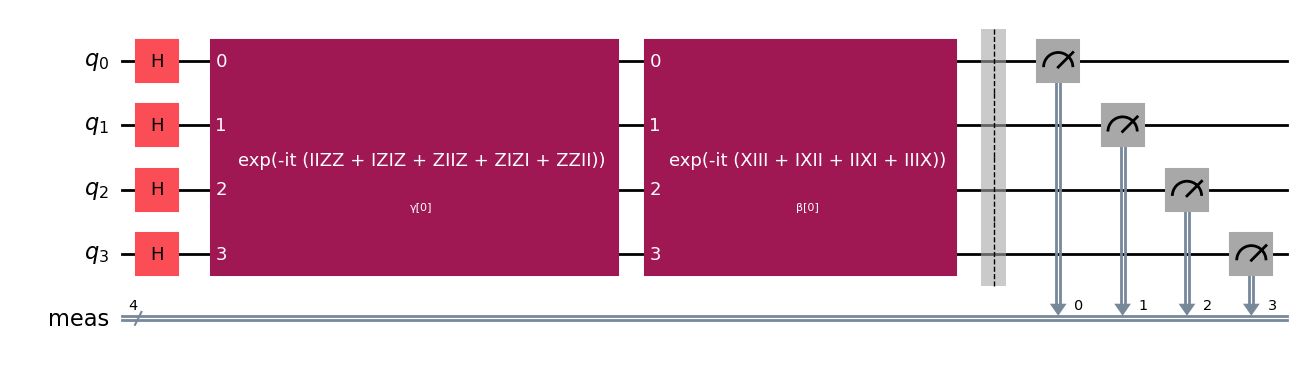

In [9]:
'''The corresponding quantum circuit for QAOA where the operator with Z terms is the Cost Hamiltonian circuit
and the one with X terms is the Mixer Hamiltonain cictuit
'''
qaoa_mes.ansatz.decompose().draw(output='mpl')
